# 监督者模式

[多智能体系统](https://docs.langchain.com/oss/python/langchain/multi-agent#multi-agent)（MAS, Multi-Agent Systems）有很多种模式，比如 Supervisor 和 Handoff。

目前最实用的依然是监督者模式（Supervisor）。它的工作流程是这样的：

1. 一个 Agent 充当监督者，负责将任务拆解成具体步骤，交给 **工具节点** 或 **工具 Agent** 执行
2. 工作节点将执行结果返回给监督者，再由监督者汇总结果，返回给用户

执行流程如下：

```mermaid
flowchart LR
    A[用户] --> B[Supervisor]
    B -.-> C[工具节点]
    B -.-> D[工具Agent 1]
    B -.-> E[工具Agent 2]
    C -.-> B
    D -.-> B
    E -.-> B
    B --> F[AI回复]
```

在 LangGraph 中，有两种实现监督者模式的具体方法：

- 使用 LangChain 的 [tool-calling](https://docs.langchain.com/oss/python/langchain/multi-agent#tool-calling) 实现
- 使用 [langgraph-supervisor](https://github.com/langchain-ai/langgraph-supervisor-py) 包实现

下面我将依次实现两种方法。

In [1]:
import os

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor

# 加载模型配置
_ = load_dotenv()

# 加载模型
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="Qwen/Qwen3-8B",
    temperature=0.7,
)

@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide two numbers."""
    return a / b

## 一、使用 `tool-calling` 功能实现

我们首先使用 `create_agent` 创建 `subagent1` 和 `subagent2`，分别用于计算 **两数相加** 和 **两数相乘**。然后使用 `@tool` 装饰器包装两个 Agent，做成 `call_subagent1` 和 `call_subagent2`两个工具，它们仅传出 Agent 的最后一条信息。

In [2]:
# 创建subagent1：用于计算两数相加
subagent1 = create_agent(
    model=llm,
    tools=[add],
    name="subagent-1",
)

@tool(
    "subagent-1",
    description="可以准确地计算两数相加"
)
def call_subagent1(query: str):
    result = subagent1.invoke({
        "messages": [{"role": "user", "content": query}]
    })
    return result["messages"][-1].content

# 创建subagent2：用于计算两数相乘
subagent2 = create_agent(
    model=llm,
    tools=[multiply],
    name="subagent-2",
)

@tool(
    "subagent-2",
    description="可以准确地计算两数相乘"
)
def call_subagent2(query: str):
    result = subagent2.invoke({
        "messages": [{"role": "user", "content": query}]
    })
    return result["messages"][-1].content

现在，我们可以将 `call_subagent1`、`call_subagent2`、`divide` 作为工具，直接传入 `supervisor_agent`.

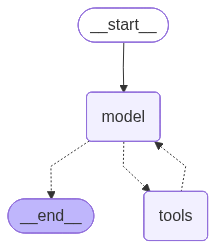

In [9]:
# 创建supervisor agent
supervisor_agent = create_agent(
    model=llm,
    tools=[call_subagent1, call_subagent2, divide],
    name="supervisor-agent",
    system_prompt="提示：如遇两数相减仍可用两数相加工具实现，只需将一个数加上另一个数的负数",
)

supervisor_agent

下面，我们来计算 `38462 + 378 / 49 * 83723 - 123`，看它能否正确地使用所有工具。

In [4]:
result = supervisor_agent.invoke({
    "messages": [{"role": "user", "content": "计算 38462 + 378 / 49 * 83723 - 123 的结果"}]}
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

计算 38462 + 378 / 49 * 83723 - 123 的结果
================================== Ai Message ==================================
Tool Calls:
  divide (019ac8fbb938589ace9ef87daa09f3e4)
 Call ID: 019ac8fbb938589ace9ef87daa09f3e4
  Args:
    a: 378
    b: 49
================================= Tool Message =================================
Name: divide

7.714285714285714
================================== Ai Message ==================================
Tool Calls:
  subagent-2 (019ac8fbcb5460c11e4878b8a096e461)
 Call ID: 019ac8fbcb5460c11e4878b8a096e461
  Args:
    query: 7.714285714285714 * 83723
================================= Tool Message =================================
Name: subagent-2

The result of multiplying $7.714285714285714$ by $83723$ is $645863.1428571428$.
================================== Ai Message ==================================
Tool Calls:
  subagent-1 (019ac8fbeb14dfa7e3aab488ee9f4445)
 Call ID

In [5]:
# 验证结果是否正确
38462 + 378 / 49 * 83723 - 123

684202.1428571428

## 二、使用 `langgraph-supervisor` 包实现

要使用 [langgraph-supervisor](https://github.com/langchain-ai/langgraph-supervisor-py)，首先需要安装 `langgraph-supervisor` 包：

```bash
pip install -U langgraph-supervisor
```

`langgraph-supervisor` 提供了 `create_supervisor` 函数。该函数接受多个 Agent 作为入参，并通过 supervisor 调用它们。

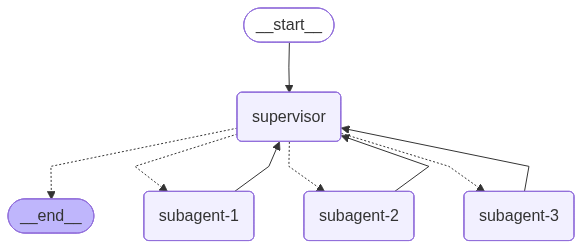

In [ ]:
subagent3 = create_agent(
    model=llm,
    tools=[divide],
    name="subagent-3",
)

supervisor_graph = create_supervisor(
    [subagent1, subagent2, subagent3],
    model=llm,
    prompt="提示：如遇两数相减仍可用两数相加工具实现，只需将一个数加上另一个数的负数"
)

supervisor_app = supervisor_graph.compile()

supervisor_app

In [10]:
result = supervisor_app.invoke({
    "messages": [{"role": "user", "content": "计算 38462 + 378 / 49 * 83723 - 123 的结果"}]}
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

计算 38462 + 378 / 49 * 83723 - 123 的结果
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_subagent-1 (019ac8ff00e58830cf1d4fb3c2373b20)
 Call ID: 019ac8ff00e58830cf1d4fb3c2373b20
  Args:
================================= Tool Message =================================
Name: transfer_to_subagent-1

Successfully transferred to subagent-1
================================== Ai Message ==================================

计算结果是 44132.0。
================================== Ai Message ==================================
Name: subagent-1

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (2a9f2189-7415-4260-855b-a1bd6954351c)
 Call ID: 2a9f2189-7415-4260-855b-a1bd6954351c
  Args:
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back

In [11]:
# 验证结果是否正确
38462 + 378 / 49 * 83723 - 123

684202.1428571428

别看现在它们都算对了，实际上这是我试了好几遍，并调整了 system prompt 的结果。你多次尝试应该也能 roll 出错误的结果。所以我对多智能体的效果仍有疑虑。我感觉现阶段多智能体是会降低准确性的，能不用就不用。什么时候应该使用多智能体呢？可以参考以下 LangGraph 给的 [建议](https://docs.langchain.com/oss/python/langchain/multi-agent)。

> 多代理系统在以下情况下很有用：
> - 单个代理拥有太多工具，并且在使用哪个工具方面做出了错误的决定。
> - 上下文或内存变得太大，一个代理无法有效跟踪。
> - 任务需要专业化 （例如，规划师、研究人员、数学专家）。